In [2]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from imexam.imexamine import Imexamine
from astropy.coordinates import SkyCoord

Ginga not installed, use other viewer, or no viewer


In [3]:
# grab show_image
phot_tutorial_dir = '/Users/Kira Simpson/Desktop/ASTR8060/repositories/notebooks'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [4]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [8]:
# define directories
data_dir = '/Users/Kira Simpson/Desktop/ASTR8060/data/Imaging/'
reduced_dir = '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/' #working directory

## 1. Find bright stars in the middle of frame

The star finder implemented in PHOTUTILS is an implementation of <a href="https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract">DAOPHOT</a>. It looks for peaks in the distribution of pixel values in an image. We have to do extra tests to distinguish between stars, random noise spikes, and extended sources such as galaxies.


<b>Answering questions about DAOPHOT:</b>
 - How do you control how faint the stars you find are? <br>
     - threshold parameter
 - How do you avoid saturated stars?<br>
     - using parameters like sharpness/roundness
 - What is sharpness?<br>
     - sharpness measures the value of a central pixel in relation to the pixels around it, so if a central pixel is brightest, how bright are the surrounding pixels.
 - What is roundness?<br>
     - when a pixel saturates, its potential well overflows into the surrounding pixels, making a streak-like shape when the detector reads out instead of a circular point source. Roundness is a measure of how circular a bright source is, so roundness=0. If the pixel 'overflows' in the x or y direction the roundness will be negative or positive respectively.

<b>Read in the data and plot the image</b>

Plot the central part of the frame for columns 750-1250 and rows 1000-1500 for a085otzf.fits.

In [11]:
# read in the data
#data = CCDData.read(data_dir+'a085.fits',unit='adu').data
data = fits.open(reduced_dir+'a085otz.fits')
a085data = data[0].data

In [12]:
# set the column and row range of interest
row_lo = 999
row_hi = 1499
col_lo = 749
col_hi = 1249

<ipython-input-13-30caf6a94d28>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks()+col_lo)
<ipython-input-13-30caf6a94d28>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()+row_lo)


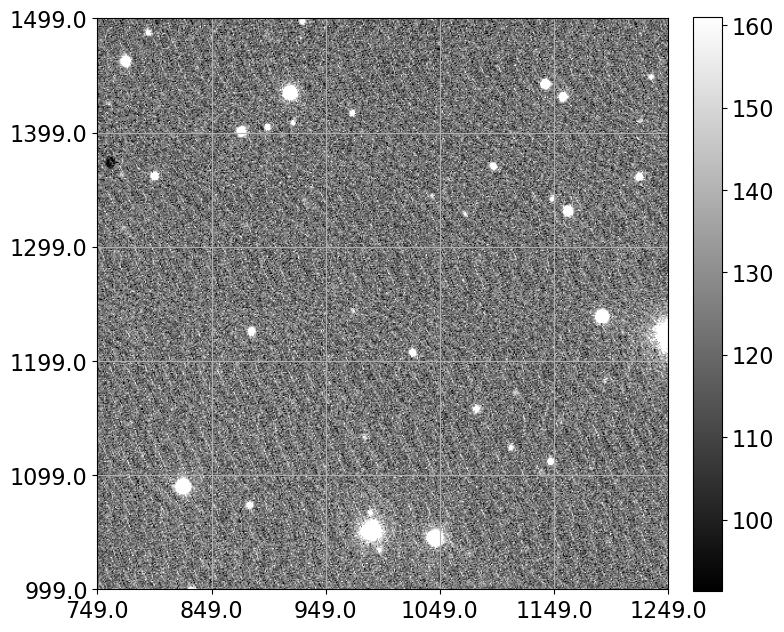

In [13]:
# plot only the center of the frame from col_lo to col_hi and row_lo to row_hi
# the tricky part here is to make sure the axis labels have the right values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(a085data[row_lo:row_hi,col_lo:col_hi], cmap='gray', ax=ax, fig=fig)
ax.set_xticklabels(ax.get_xticks()+col_lo)
ax.set_yticklabels(ax.get_yticks()+row_lo)
plt.tight_layout()
plt.show()

<b> Find the bright stars using the Star Finder example code </b>

In [26]:
# write code based on the example notebook
# the line below is just to show you what the "sources" variable should be for later cells
data = a085data[row_lo:row_hi,col_lo:col_hi]  
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std)) 

daofind = DAOStarFinder(fwhm=3.0, threshold=4.*std)  
sources = daofind(data - median)
print(sources)

#make a lil table
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output

#sources = daofind(data) 

(123.68436316464347, 123.63027479855847, 12.052373078575686)
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
  1 246.96963979230324 ... 1.0615781030980793   -0.06487987966696655
  2  295.7739544675617 ...  93.51350664718868     -4.927185857093166
  3 239.84011246190806 ...  225.1457213334512      -5.88115924512581
  4   27.5362705210291 ... 1.1630894989201515   -0.16403283667420127
  5 238.90234557036047 ... 1.0018827294535109  -0.002042225654929775
  6  152.4678017271431 ... 1.0056902284736635   -0.00616057609993006
  7 133.11732566081477 ...  2.479692217737949    -0.9859944475965738
  8  74.80388757603482 ...  73.56093207259899     -4.666618058600457
  9 396.49564506370575 ... 2.0236764152035107    -0.7653526756486921
 10 361.84031687280736 ... 1.1650436810444988   -0.16585552173332488
...                ... ...                ...                    ...
 27 171.27669326740906 ... 1.2632734707644

<b> Plot the image again and mark the detected stars </b>

Making apertures at the position of the stars you detect would be a good method for showing where they are.

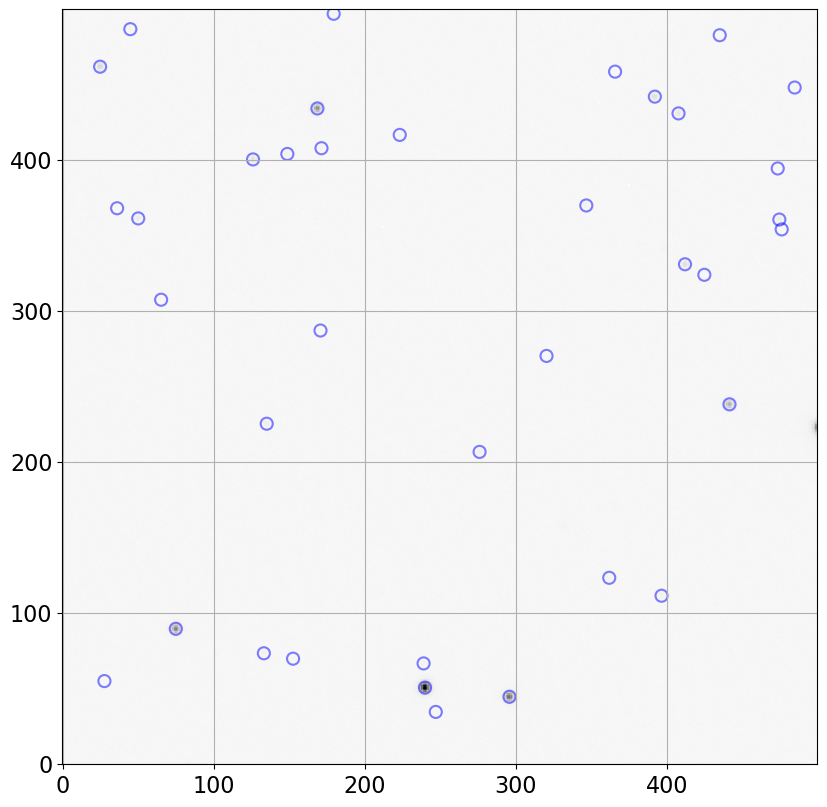

In [27]:
positions = [(x,y) for x,y in zip(sources['xcentroid'],sources['ycentroid'])] # this syntax is handy for apertures
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
            interpolation='nearest')
#show_image(a085data[row_lo:row_hi,col_lo:col_hi], cmap='gray', ax=ax, fig=fig)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

## 2. Measure the PSF FWHM

The point spread function (PSF) full width at half maximum (FWHM) is a measure of the width in pixels where light from a point source is distributed on the CCD. Many of the detection methods above take the PSF FWHM as an input to help distinguish from noise spikes. Also, you may want to explore the PFS as a function of time or position on the CCD. Thus, it is worthwhile to know how to measure it.

A simple estimate for the PSF FWHM would find the 1D Gaussian distribution of light from a single star in a column or row and determine its width. More complex algorithms include centroiding, 2D model fitting, and background subtraction. The imexam package includes these and many more tools. 

(Imexam also has many interactive tools and can run with DS9, but it is finicky to get the display set up. See the accompanying notebook if you are feeling extremely bold.)


We will use imexam to create a radial profile plot. This shows the azimuthally averaged value of the counts in a frame as a function of radius from the star centroid. The FWHM is taken from the width of this (Gaussian) profile.

A warning about the radial profiles in imexam: they can fail with various errors if the position is near the edge of the frame.

<b>Calculate the FWHM for the sources you found in the previous step.</b>

In [28]:
#initalize the object to get access to the plotting functions
plots=Imexamine() 

xc=1223.4883	yc=1359.3152
Background per pixel: 122.82412313763162
Max. pix. flux =   286.651
amp =   265.131
fwhm =     3.213


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


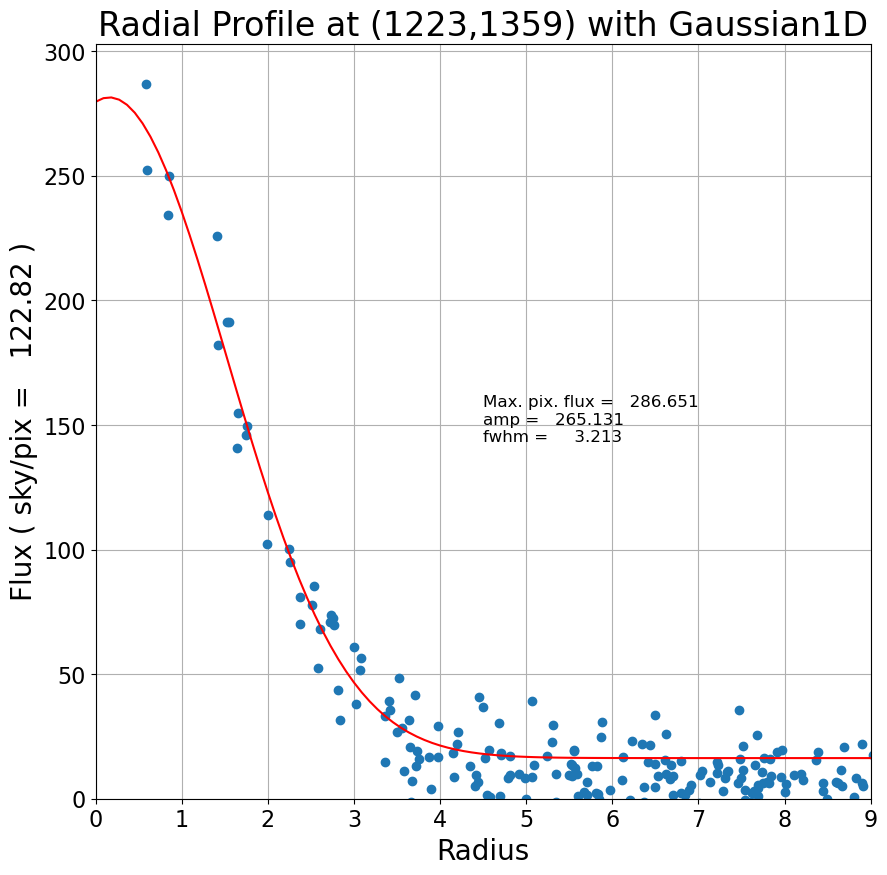

xc=798.9194	yc=1360.0265
Background per pixel: 122.9813958391994
Max. pix. flux =   310.548
amp =   303.095
fwhm =     3.500


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


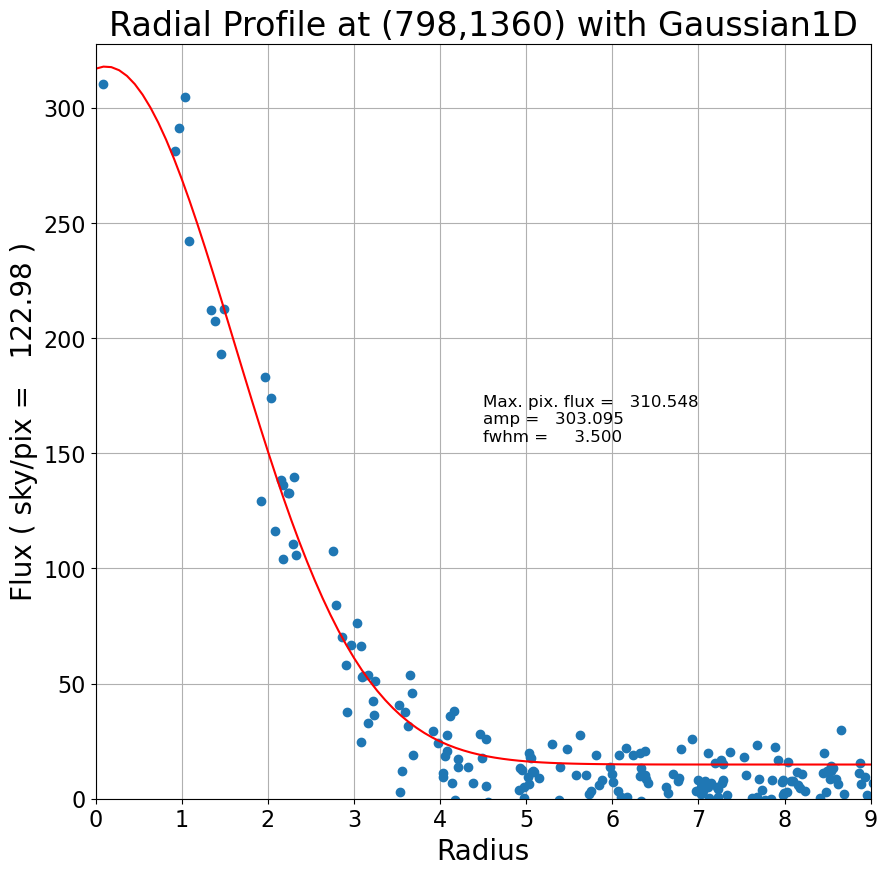

xc=50.0938	yc=1363.3443
Background per pixel: 121.8214583154421
Max. pix. flux =  1783.904
amp =  1909.923
fwhm =     3.962


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


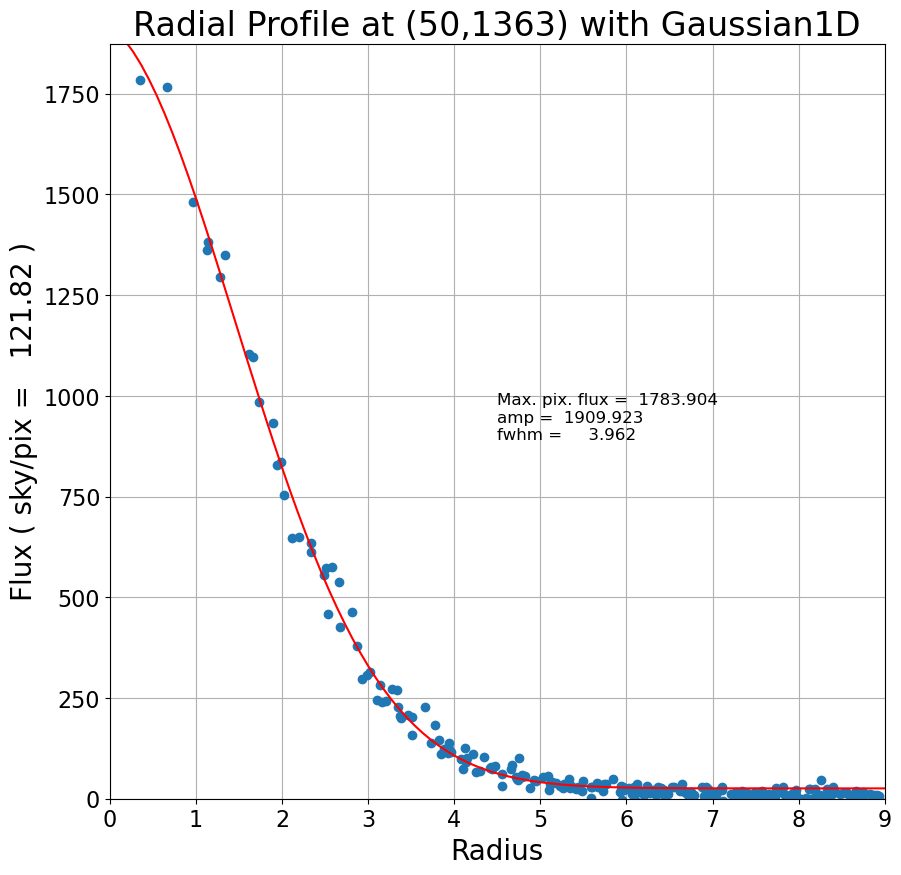

xc=1449.9629	yc=1327.3990
Background per pixel: 124.20323561648394
Max. pix. flux =   798.174
amp =   815.384
fwhm =     3.778


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


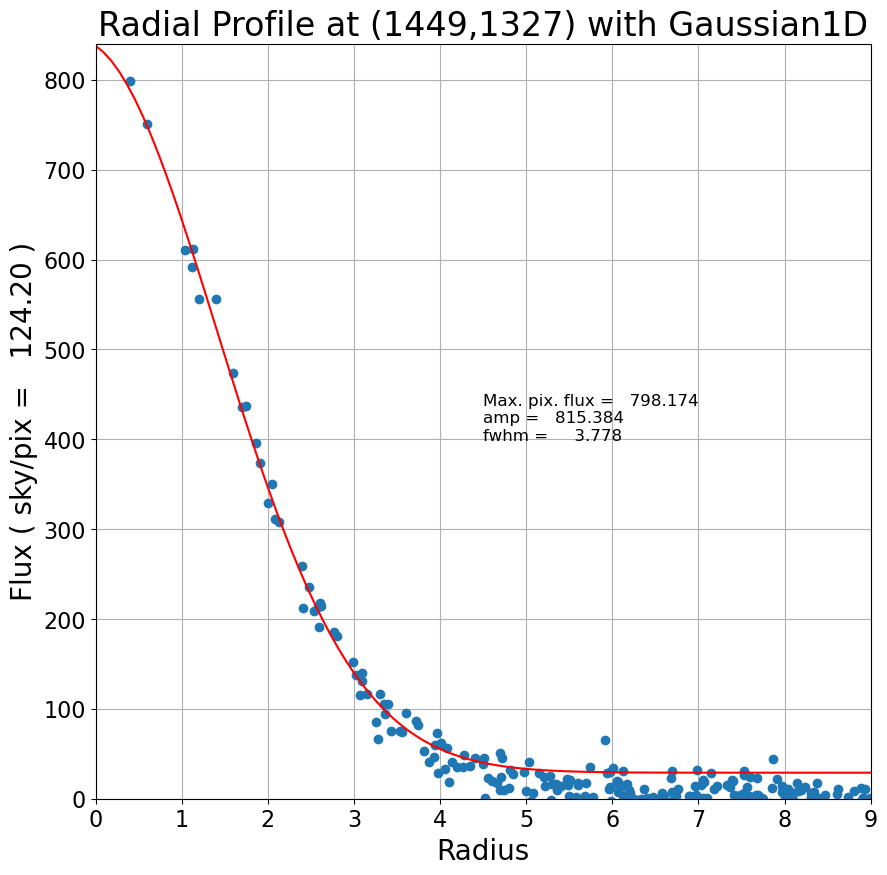

xc=1853.8595	yc=1353.4186
Background per pixel: 121.13377152658943
Max. pix. flux =   477.230
amp =   473.208
fwhm =     3.756


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


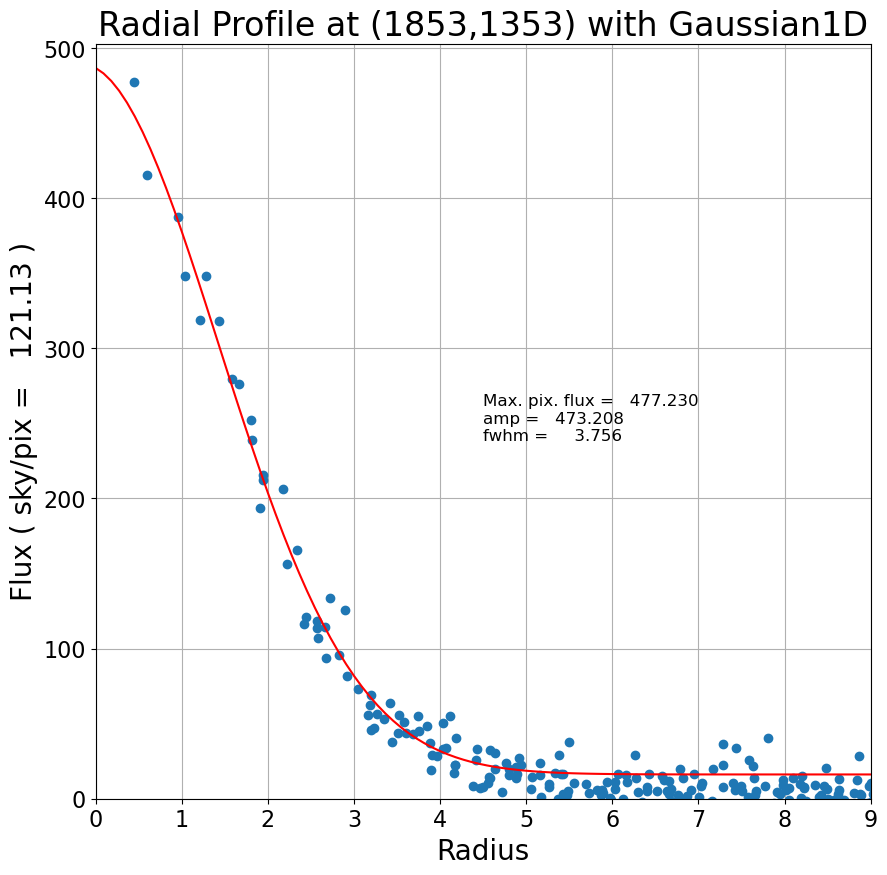

In [40]:
#testing column variation
plots.radial_profile(1223,1362,a085data,genplot=True)
plots.radial_profile(800,1361,a085data,genplot=True)
plots.radial_profile(51,1365,a085data,genplot=True)
plots.radial_profile(1451,1327,a085data,genplot=True)
plots.radial_profile(1854,1355,a085data,genplot=True)

# loop over the x and y centroids from the star finder
# and generate a radial profile for each one
# how much does the FWHM vary between these?
#for x,y in zip(sources['xcentroid'],sources['ycentroid']):
#    print(x,y) # dummy loop, add code here to do radial profiles


xc=70.2527	yc=1900.0001
Background per pixel: 124.66593700558751
Max. pix. flux =  3781.296
amp =  3958.946
fwhm =     4.165


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


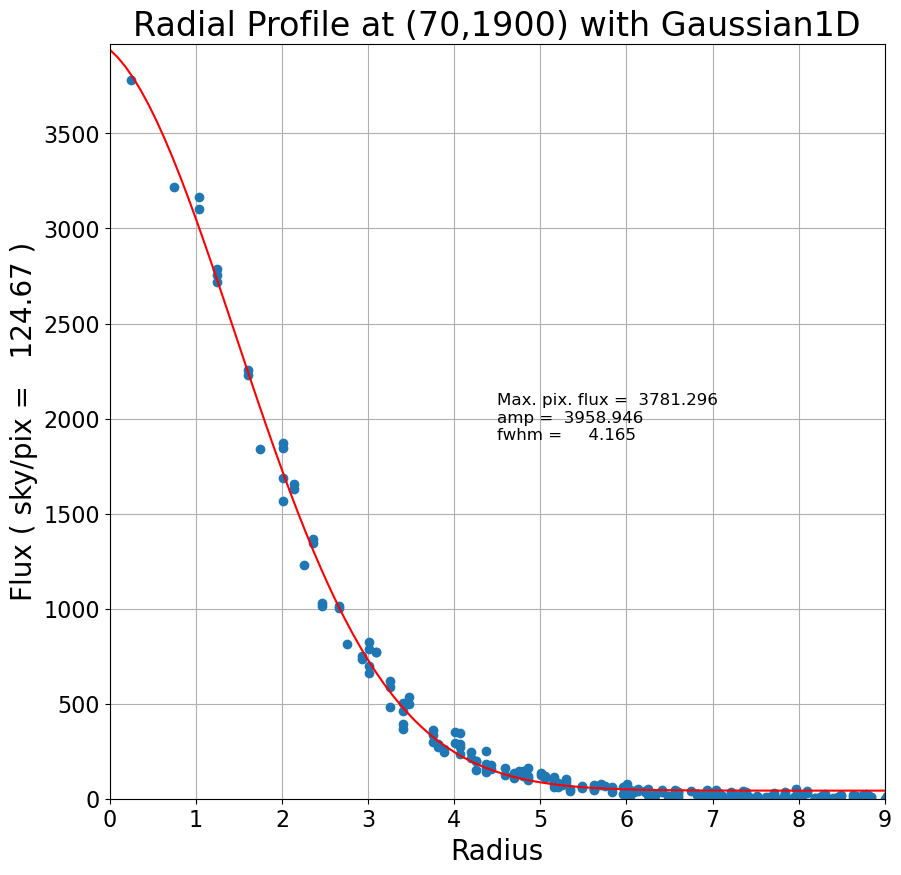

xc=50.0938	yc=1363.3443
Background per pixel: 121.82145919787474
Max. pix. flux =  1783.904
amp =  1909.923
fwhm =     3.962


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


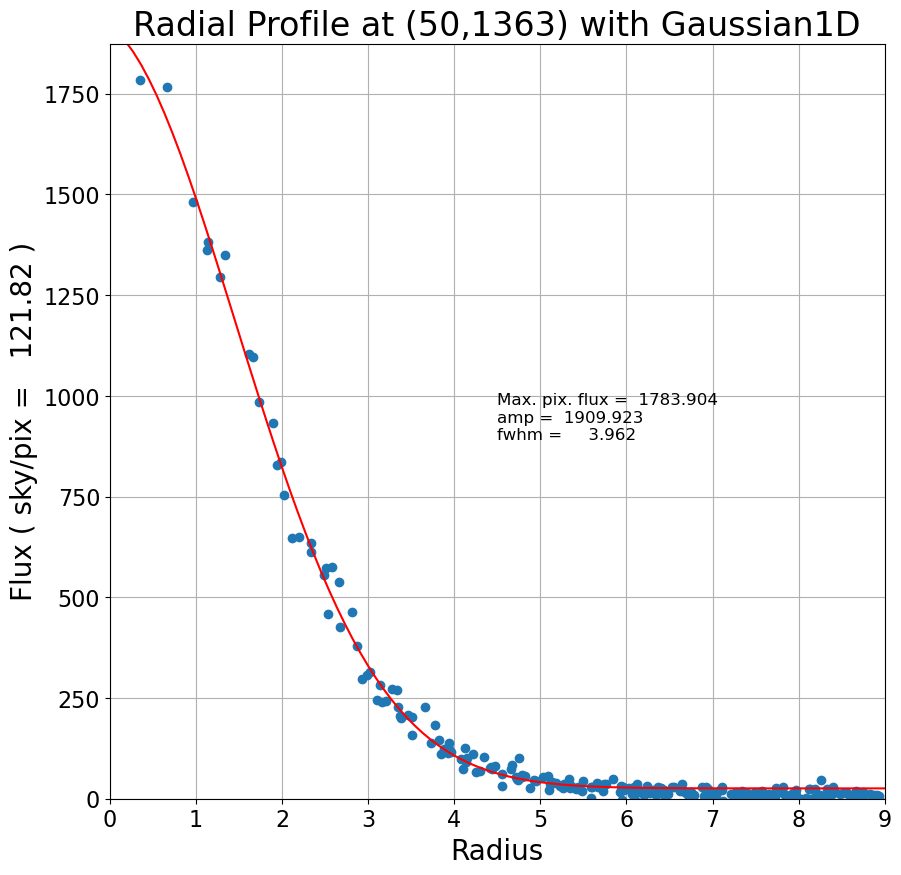

xc=39.1072	yc=830.2241
Background per pixel: 128.01452979916198
Max. pix. flux =  7199.877
amp =  7583.249
fwhm =     4.113


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


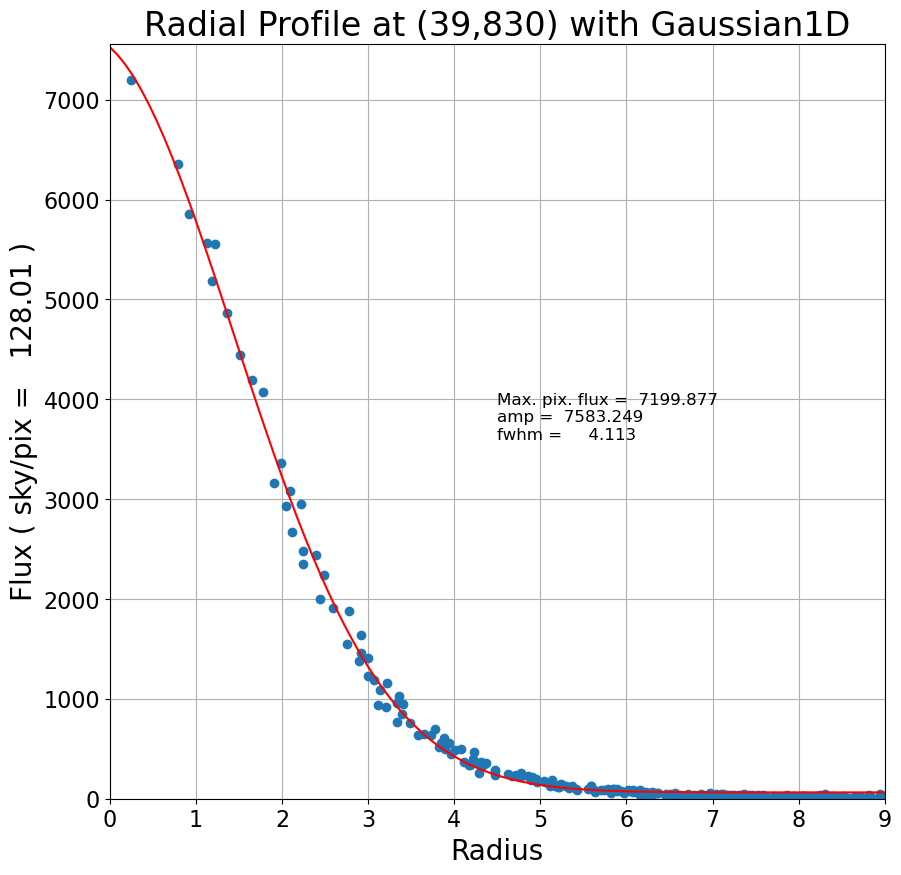

xc=46.3050	yc=675.5157
Background per pixel: 123.80575808261504
Max. pix. flux =  3031.555
amp =  3466.708
fwhm =     4.162


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


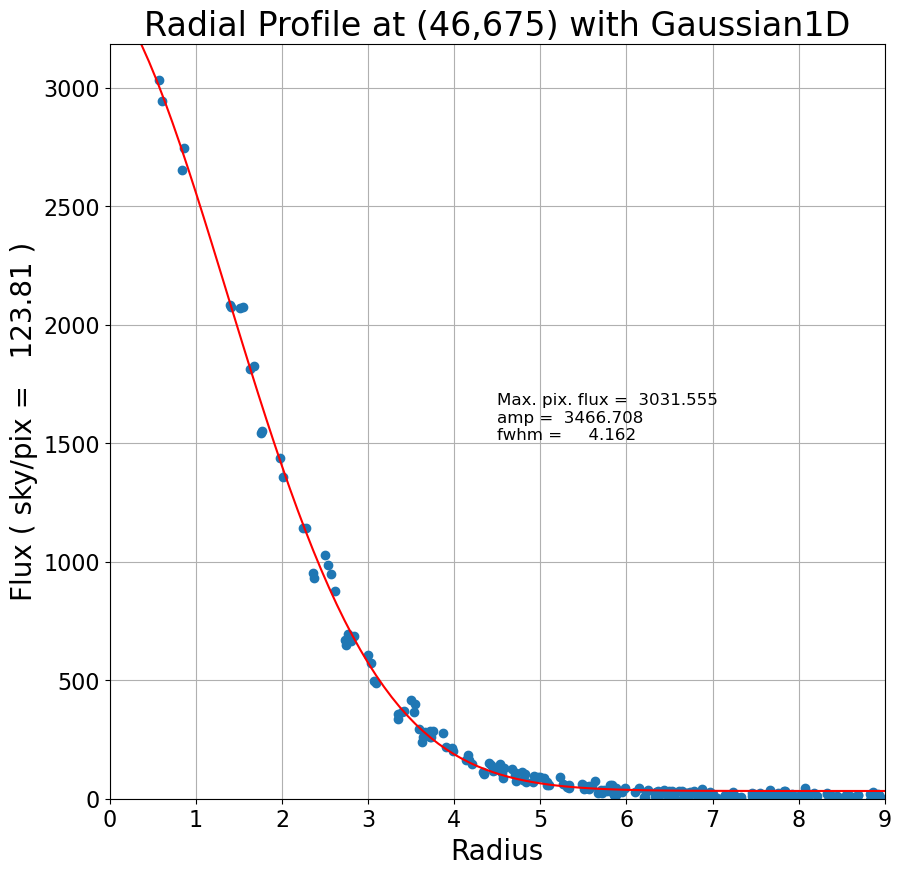

xc=55.9974	yc=255.9816
Background per pixel: 121.74430873027896
Max. pix. flux =  1636.064
amp =  1632.154
fwhm =     3.768


C:\Users\Kira Simpson\anaconda3\lib\site-packages\imexam\math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


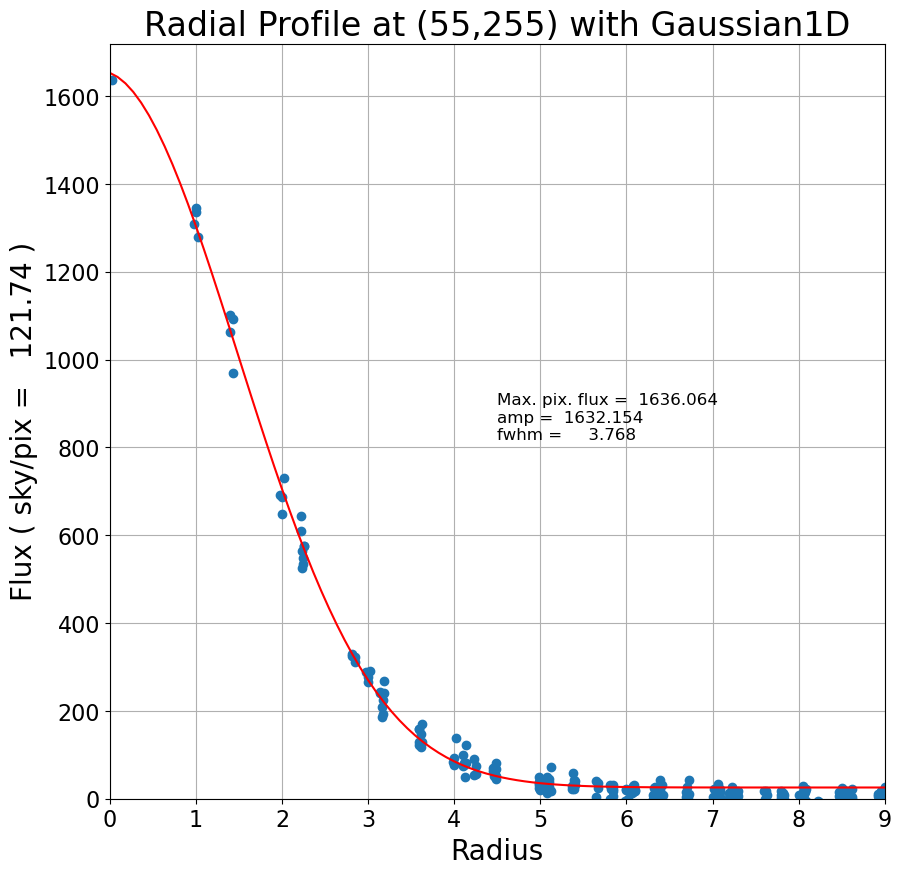

In [44]:
#testing row variation
#ягишна 

plots.radial_profile(71,1900,a085data,genplot=True)
plots.radial_profile(51,1363,a085data,genplot=True)
plots.radial_profile(40,831,a085data,genplot=True)
plots.radial_profile(46,677,a085data,genplot=True)
plots.radial_profile(56,258,a085data,genplot=True)



In [ ]:
## 3. Write a function to do aperture photometry

Write a function that takes a filename and:

1. Reads in the data.
2. Finds all the sources in the image.
3. Puts a circular aperture and background annulus on each of the stars.
4. Calculates background-subtracted instrumental magnitudes.
5. Plots the image and apertures for visual inspection.
6. Returns a table of photometry, including the instrumental magnitudes.

Run your function on a085otzf.fits.

In [52]:
def get_phot(filename):
    #getchyer data
    data = CCDData.read(reduced_dir+filename,unit='adu').data
    # do photometry
    #get the mean, median, std
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    
    daofind = DAOStarFinder(fwhm=3.0, threshold=4.*std)  
    sources = daofind(data - median)
    
    #make a lil table
    for col in sources.colnames:  
        sources[col].info.format = '%.8g'  # for consistent table output
        
    positions = [(x,y) for x,y in zip(sources['xcentroid'],sources['ycentroid'])] # this syntax is handy for apertures
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
            interpolation='nearest')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    phot_table = aperture_photometry(data, apertures)
    phot_table['aperture_sum'].info.format = '%.8g'
    
    return phot_table

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,873.5213080034746,0.7828464721624113,423076.37
2,1929.3670828052636,2.215312191579093,9883.5314
3,107.56729527747997,4.653603070949242,6870.2266
4,688.0159494462243,3.951292865918579,8955.1967
5,127.70702192580241,5.52034642256188,8550.3546
6,1450.2381580700908,6.060184953060559,8819.0786
7,7.998371011067169,9.476867688275863,7711.5724
8,1953.877187208898,10.860395577380523,14016.769


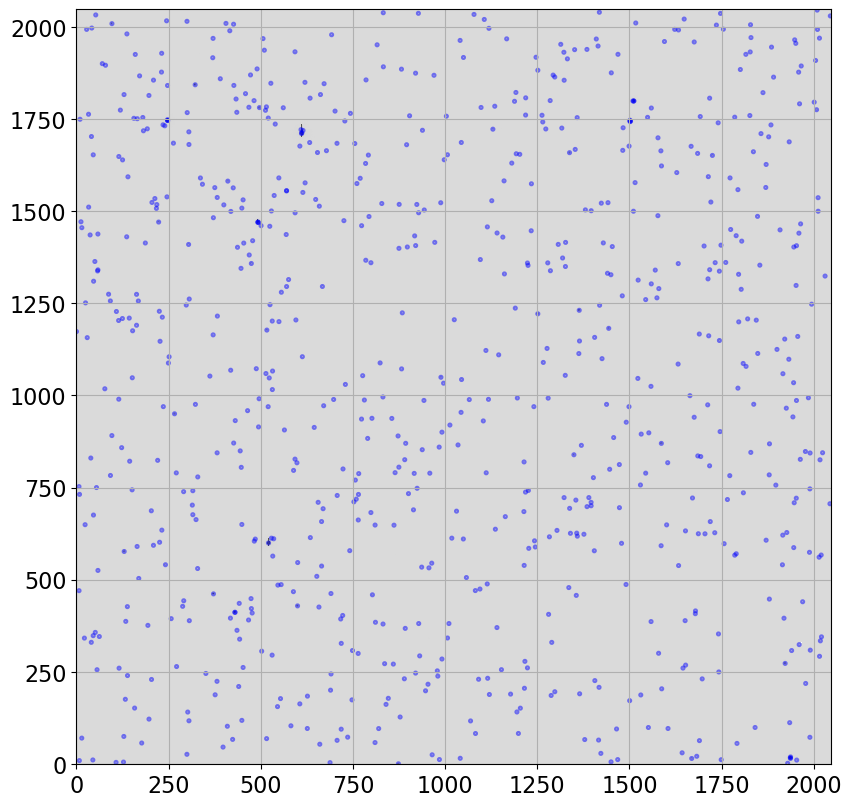

In [53]:
phot = get_phot('a085otzf.fits')
phot

# 2.) Linearity of a CCD

In [69]:
#frames 74-80
#make plot of ADU vs time
#determine whether chip is linear to the full 16 bits of the A-D converter
#take each image
#take average of all the pixels in each image (so avg of all the counts)
#plot against time
#get time, use datetime function in prev homework

lt_dir = '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/'

nfiles_lt = 7
nlow_lt = 74
lintest_files = ['a'+str(i).zfill(3)+'ot.fits' for i in np.arange(nfiles_lt)+nlow_lt]
print(lintest_files)
#LINEARITY TEST FILES
hdus_lt = [fits.open(reduced_dir+file) for file in lintest_files]

#print(hdus_lt)
hdrs_lt = [hdu[0].header for hdu in hdus_lt]
lt_data = [hdu[0].data for hdu in hdus_lt]

print(np.size(hdus_lt))

for i in range(np.size(lintest_files)):
    
    # add header keywords for BIASSEC, TRIMSEC, FILTER, and IMAGETYPE
    hdrs_lt[i]['IMAGETYP'] = 'LinTest'
    hdrs_lt[i]['FILTER'] = 'None'
    hdrs_lt[i]['BIASSEC'] = '[2101:2048,0:2048]'
    hdrs_lt[i]['TRIMSEC'] = '[53:2101,0:2048]'
    
    # write the fits file out with the new header keywords
    # note that you have to write out the whole HDU - i.e. the data+header package
    hdus_lt[i].writeto(lt_dir+lintest_files[i], overwrite = True)
    
print(hdrs_lt)    

#windows systems will think a file is still open/being used unless you delete the pointer
#so make sure to delete the pointers to the files so the os thinks they're closed
del hdus_lt # hdus take a lot of memory, don't leave them open when you don't need to
del hdrs_lt
del lt_data

['a074ot.fits', 'a075ot.fits', 'a076ot.fits', 'a077ot.fits', 'a078ot.fits', 'a079ot.fits', 'a080ot.fits']
7
[SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2009-09-15T15:56:24' / Date FITS file was generated                  
IRAF-TLM= '09:56:23 (15/09/2009)' / Time of last modification                   
DATAMIN =           0.000000E0 / Minimum data value                             
DATAMAX =           4.527400E4 / Maximum data value                             
OBJECT  = 'pg1633  '           / Name of the object observed                    


In [70]:
#now take average of all these lintest frames
imgs = ccdp.ImageFileCollection(lt_dir,glob_include='a*.fits') 

lt_files = imgs.files_filtered(imagetyp='LinTest',filter='None',include_path=True)

['/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/a074ot.fits',
 '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/a075ot.fits',
 '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/a076ot.fits',
 '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/a077ot.fits',
 '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/a078ot.fits',
 '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/a079ot.fits',
 '/Users/Kira Simpson/Desktop/ASTR8060/data/im_reduc/linearity_test/a080ot.fits']

In [71]:
lt_data = [CCDData.read(lt_files[i],unit='adu') for i in range(len(lt_files))]

file_names = [lt_files[i] for i in range(len(lt_data))]

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [72]:
times = imgs.filter(imagetyp='LinTest',filter='None').summary['date-obs'].data.data 

lt_times = [datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.%f') for time in times] # these are nicely formatted for plotting

[5635.045405520375, 1875.0771834128007, 5045.463158947588, 34606.91745719615, 55278.14414883387, 63792.09849674798, 64869.86154518312]


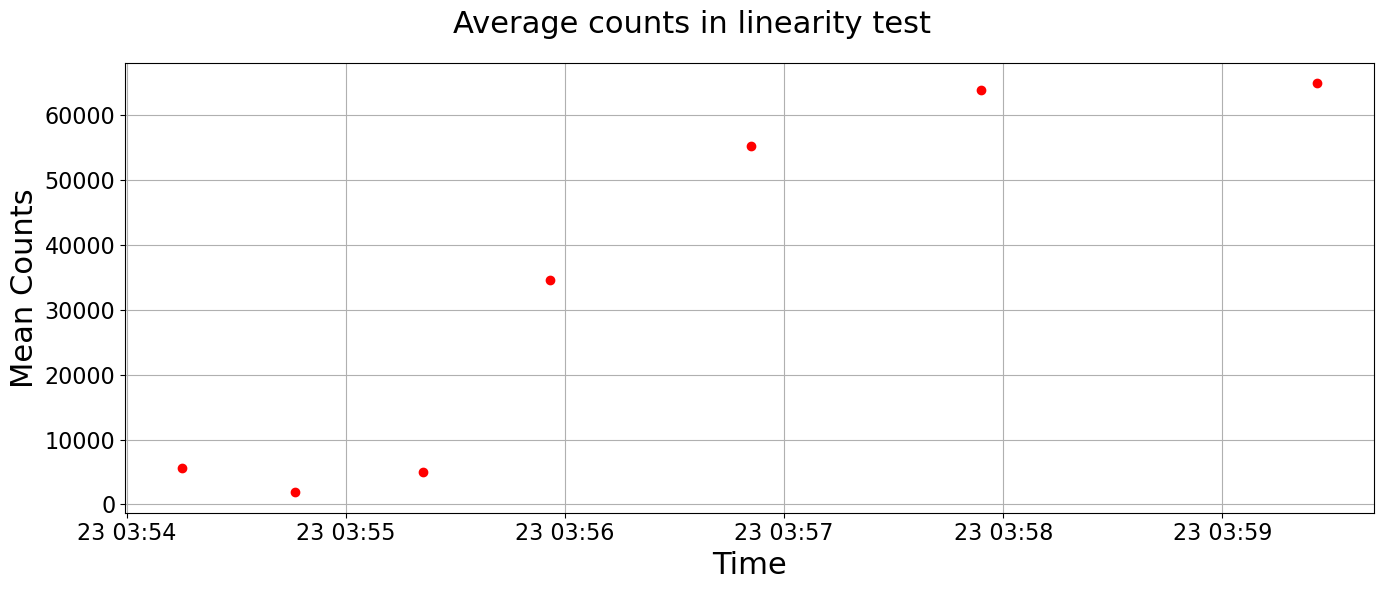

In [76]:
#find the peak pixel??
means  = [np.mean(one_file.data[1709:1716,613:617]) for one_file in lt_data]
print(means)

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(lt_times,means,'red',marker='o',ls='')
ax.set_xlabel(r'Time',fontsize=22)
ax.set_ylabel(r'Mean Counts',fontsize=22)
fig.suptitle('Average counts in linearity test', fontsize=22)
fig.tight_layout()
plt.show()

# 3.) SNR (use apertures notebook)

Use photutils to perform aperture photometry on three (non saturated) stars in the
PG1633+099 standard field: a really faint one, a medium bright one, and a bright one.
Perform aperture photometry using at least 5 aperture sizes from very small to very large
and make a plot that reproduces the one from Howell Figure 5.7 showing S/N as a function
of aperture radius. What is a good aperture size to use for this dataset?

In [172]:
data = CCDData.read(reduced_dir+'a081otzf.fits',unit='adu').data

# this will choose three star positions
# insert the position of three stars from DS9 from the notes above
#one bright, one middle-bright, and one faint
x1 = 1365. #bright star
x2 = 1268.21
x3 = 1446.4211
y1 = 1232.
y2 = 1090.26
y3 = 1181.939
positions = [(x1,y1),(x2,y2),(x3,y3)]

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Aperture: CircularAnnulus
positions: [[1365.    , 1232.    ],
            [1268.21  , 1090.26  ],
            [1446.4211, 1181.939 ]]
r_in: 15.0
r_out: 20.0


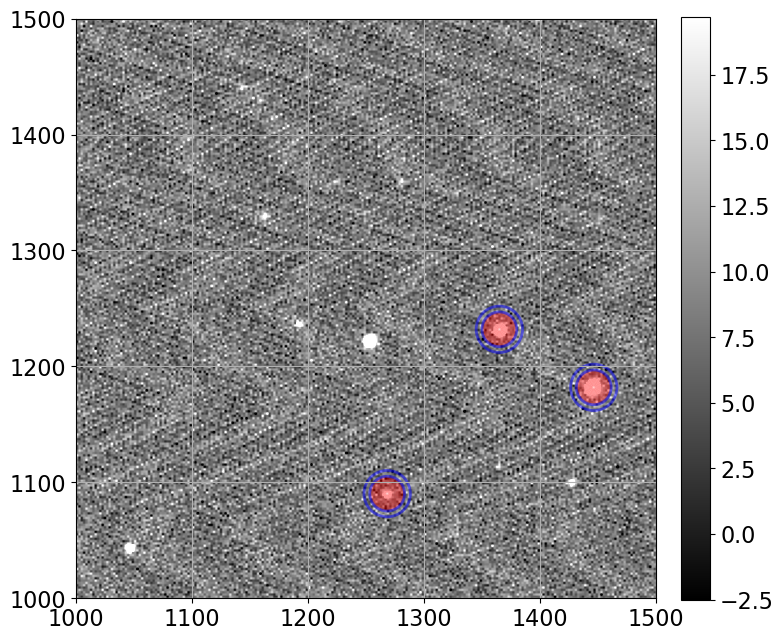

In [187]:
#create apertures
radii = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12., 13., 14.]
circ_apertures = [CircularAperture(positions, r=r) for r in radii]

annulus_apertures = CircularAnnulus(positions, r_in=15., r_out=20.)
print(annulus_apertures)

#plot all the apertures together to see how well the stars are covered by the different aperture sizes
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(data, cmap='gray', ax=ax, fig=fig)

for ap in circ_apertures:

    ap.plot(color='red', lw=2, alpha=0.2)# apertures
    

# add the annulus
annulus_apertures.plot(color='blue', lw=2, alpha=0.5)

# ax.set_xlim([250,750])
# ax.set_ylim([1250,1750])

ax.set_xlim([1000,1500]) # use these to zoom in/out
ax.set_ylim([1000,1500])
plt.tight_layout()
plt.show()

In [174]:
#calculate photometry
#phot_table = aperture_photometry(data, circ_apertures)
#phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output

phot_table = aperture_photometry(data, circ_apertures)
bkg_tot = aperture_photometry(data, annulus_apertures)
print(bkg_tot['aperture_sum'])
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
#print(phot_table)

# for col in bkg_table.colnames:
#     bkg_table[col].info.format = '%.8g'
# print(bkg_table)

#phot_table['annulus_sum'].info.format = '%.8g'
#print(phot_table)

   aperture_sum  
-----------------
4599.025624336178
4516.249061353943
4713.842750789584


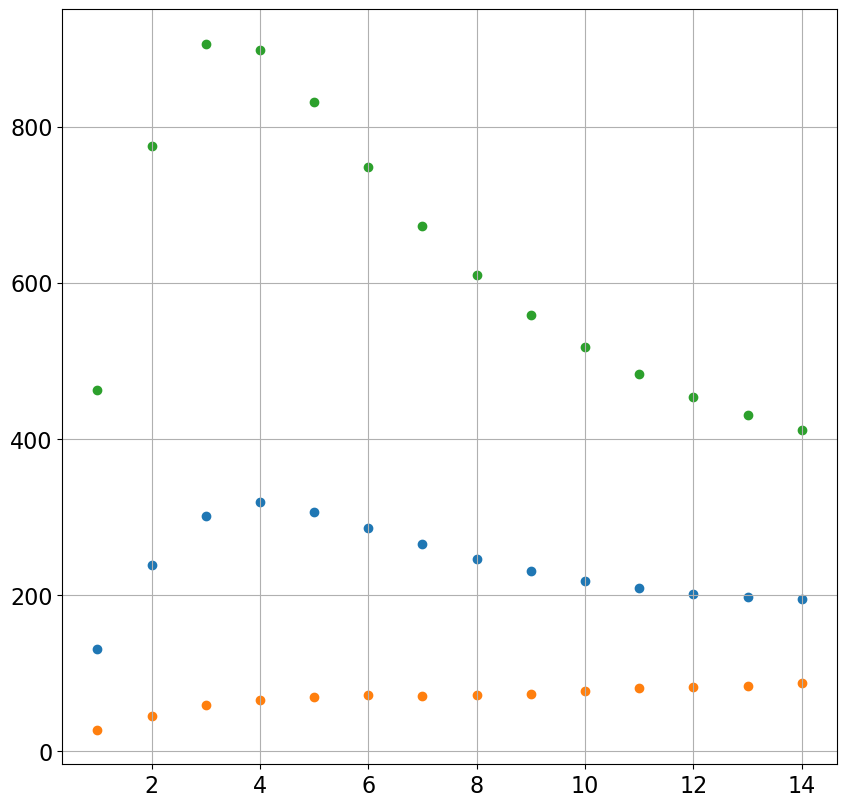

In [189]:
stars_dict = {}
keys = ['star1','star2','star3']

for i in range(3):
    snrs = []
    for n, col in enumerate(phot_table.colnames):
        #print(str(n)+' '+col)
        if 'aperture' not in col:
            continue
        else:
            snr = phot_table[col][i]/np.sqrt(circ_apertures[n-3].area*bkg_tot['aperture_sum'][i]/annulus_apertures[i].area)
            snrs.append(snr)
    #print(snrs)
    stars_dict[keys[i]] = snrs
    
           
#print(stars_dict)

#with plt.style.context('fivethirtyeight'):

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(radii, stars_dict['star1'])
ax1.scatter(radii, stars_dict['star2'])
ax1.scatter(radii, stars_dict['star3'])


plt.show()


3.5 pixels is a good radius for the aperture, it's where the SNR is highest for this dataset based on the figure above.

# 4.) Landolt Std Stars in the PG1633 science frames

The images with just the standard stars are upside down with respect to the science images.

In [1]:
# %%html
# <style>
#   table {margin-left: 0 !important;}
# </style>
# <img src=“PG_field.png”>
#display the PG 1648 field
#from IPython.display import Image, display
#display(Image(filename='PG_field.png'))

# 5.) Calculate instrumental magnitudes

In [206]:
#find all values in the S=T+AB equation
#single out a range of data for starfinder to be able to find a pattern of stars that is easy to single out in any image
#match that pattern up in every single science image
#and calculate instrumental magnitudes
#these will help us with instrumental calibrations

def instrument_magnitudes(filtname):
    imgs = ccdp.ImageFileCollection(reduced_dir, glob_include='*otzf.fits')
    #the filter includes the linearity test files, so the [:-7] will exclude the filepaths
    science_imgs = imgs.files_filtered(object='pg1633',include_path=True)[:-7]
    
    hdus = [fits.open(file) for file in science_imgs]
    hdrs = [hdu[0].header for hdu in hdus]
    star_fields = [hdu[0].data[700:1500,1000:1300] for hdu in hdus]
    #star_fields = [CCDData.read(img,unit='adu').data[700:1500,100:1300] for img in science_imgs]
    
    #select a smaller range of the image that contains a pattern to find using StarFinder
    #that way I can pick stars that are easy to single out with signal clipping
    for array in star_fields:
        #get mean, median, std
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        find_stars = DAOStarFinder(fwhm=3.0, threshold=5.*std) 
        #we can choose out to 5 standard deviations
        #since the stars are the only things in the field
        
        sources = find_stars(data - median)
        
        #make a table
        for col in sources.colnames:
            sources[col].info.format = '%.8g' #gives consistent table output
            
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        
        #make apertures
        circ_aperture = CircularAperture(positions, r=3.5)
        annulus_aperture = CircularAnnulus(positions, r_in=15, r_out=20)
        aperatures = [circ_aperture, annulus_aperture]
        
        #do photometry
        phot_table = aperture_photometry(array, aperatures)
        #make a photometry table and format it
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'
            
        #now we calculate all the pieces of the S = T + AB equation
        s = phot_table['aperture_sum_0']
        a = circ_aperture.area
        #average background per pixel
        bkg_avg = phot_table['aperture_sum_1'] / annulus_aperture.area
        
        #total background in the aperture
        bkg_tot = bkg_avg*circ_aperture.area
        
        #subtract the background from 
        bkg_sub_phot = phot_table['aperture_sum_0'] - bkg_tot
        phot_table['residual_aperture_sum'] = bkg_sub_phot
        phot_table['residual_aperture_sum'].info.format = '%.8g'
        
        #now calculate a magnitude!
        i_mag = -2.5*np.log(phot_table['residual_aperture_sum'])
        phot_table['instrumental_magnitude'] = i_mag
        
    del hdus
    del hdrs
    del star_fields
    return phot_table


In [207]:
filters = ['U', 'B', 'V', 'R', 'I']
for filt in filters:
    instrument_magnitudes(filt)

OSError: [WinError 1455] The paging file is too small for this operation to complete